# **Import Packages**

In [4]:
!pip install plotly==5.4.0
!pip install chart_studio

     |████████████████████████████████| 25.3 MB 10.6 MB/s eta 0:00:01
  Attempting uninstall: plotly
    Found existing installation: plotly 4.14.3
    Uninstalling plotly-4.14.3:
      Successfully uninstalled plotly-4.14.3
     |████████████████████████████████| 64 kB 2.4 MB/s eta 0:00:01


In [6]:
import os
import time
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import style
import plotly.offline as pyoff
import plotly.graph_objs as go

from My_code.Metrics import *

from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, GridSearchCV
from catboost import CatBoostRegressor
import xgboost
from lightgbm import LGBMRegressor

style.use('seaborn-whitegrid')
os.getcwd()

'/Linux/[2021, 2022] 초분광(Hyperspectral) 데이터/[ 2022 ]/PSC'

# **함수**

## **_Train**

In [7]:
def HS_lag (data, lag_term = 3, before_y = "yes") :
    
    lag_data = data[["chlorophyll", "Year", "Month", "Day", "Hour", "Min"]]
    
    if before_y == "yes" :
        data2 = data.drop(columns = ["Year", "Month", "Day", "Hour", "Min"])
    else :
        data2 = data.drop(columns = ["chlorophyll", "Year", "Month", "Day", "Hour", "Min"])
    
    # lag_data 생성
    for i in range(1, lag_term+1) : 
        lag = data2.shift(i)
        lag.columns = lag.columns + "_lag_" + str(i)
        lag_data = pd.concat([lag_data, lag], axis = 1)

    lag_data = lag_data.iloc[lag_term :].reset_index(drop = True)  
    
    return lag_data

In [8]:
def HS_categorical (data) :

    ### 불필요한 변수 제거
    data = data.drop(columns = ["Year", "Day", "Min"])
    
    ### HS time from Hour -> "hs" or "non hs"
    morning = [10,11,12]   ;   afternoon = [13,14,15]   ;   evening = [16,17]
    
    x = data["Hour"].astype("int")
    condlist = [x.isin(morning), x.isin(afternoon), x.isin(evening)]
    choicelist = ["morning", "afternoon", "evening"]
    data["HS time"] = np.select(condlist, choicelist, "non-hs")
    data.drop(columns = "Hour", inplace = True)

    # HS time -> One-Hot encodint
    encode_hs_time = pd.get_dummies(data["HS time"], sparse = True)
    data = pd.concat([data.drop(columns = "HS time"), encode_hs_time], axis = 1)

    

    ### Season from Month -> "sprin, summer, fall, winter"
    spring = [3,4,5]   ;   summer = [6,7,8]   ;   fall = [9,10,11]
    
    y = data["Month"].astype("int")
    condlist = [y.isin(spring), y.isin(summer), y.isin(fall)]
    choicelist = ["spring", "summer", "fall"]
    data["season"] = np.select(condlist, choicelist, "winter")
    data.drop(columns = "Month", inplace = True)

    # Season -> One-Hot encodint
    encode_season = pd.get_dummies(data["season"], sparse = True)
    data = pd.concat([data.drop(columns = "season"), encode_season], axis = 1)


    # spring, summer, fall, winter 중 없는 변수 추가.
    season = ["spring", "summer", "fall", "winter"]
    for i in range(len(season)) :
        if season[i] not in data.columns :
            data[season[i]] = [0]*data.shape[0]

    return data

In [9]:
def HS_train (train_X, train_y, comp = 8) :
    
    ### 변수 구분
    category = ["spring", "summer", "fall", "winter", "morning", "afternoon", "evening", "non-hs"]
    category_X = train_X[category]
    reflec_X = train_X.filter(regex = "reflectance")
    other_X = train_X.drop(columns = (list(reflec_X.columns) + category))
    
    
    ### 표준화
    std_other = StandardScaler().fit(other_X)
    std_other_X = pd.DataFrame(std_other.transform(other_X), columns = other_X.columns).reset_index(drop = True)

    std_reflec = StandardScaler().fit(reflec_X)
    std_reflec_X = pd.DataFrame(std_reflec.transform(reflec_X), columns = reflec_X.columns).reset_index(drop = True)

    std_y = (train_y - train_y.mean())/train_y.std()


    ### PLS
    pls_fit = PLSRegression(n_components = comp).fit(std_reflec_X, std_y)
    pls_X = pd.DataFrame(pls_fit.transform(std_reflec_X), columns = ["comp" + str(i+1) for i in range(comp)]).reset_index(drop = True)

    new_train_X = pd.concat([std_other_X, pls_X, category_X], axis = 1)
    
    
    return {"new train X" : new_train_X, "pls" : pls_fit, "std other" : std_other, "std reflec" : std_reflec}    

In [10]:
def HS_model (data, MODEL, lag_term = 3, comp = 8, SEED = 999, before_y = "yes") :
    
    lag_data = HS_lag(data, lag_term = lag_term, before_y = before_y)
    categorical_data = HS_categorical(lag_data)
    
    train_X = categorical_data.drop(["chlorophyll"], axis = 1)
    train_y = categorical_data["chlorophyll"]
    
    Train = HS_train(train_X, train_y, comp)
    
    new_train_X = Train["new train X"]
    train_columns = new_train_X.columns
    train_pls = Train["pls"]
    train_std_other = Train["std other"]
    train_std_reflec = Train["std reflec"]
    
#     model = RandomForestRegressor(random_state = SEED).fit(new_train_X, np.ravel(train_y))
    model = MODEL.fit(new_train_X, np.ravel(train_y))
    

    return {"model" : model, "train pls" : train_pls, "train std other" : train_std_other, "train std reflec" : train_std_reflec, "train columns" : train_columns}

In [11]:
def HS_model_grid (data, MODEL, param_grid, lag_term = 3, comp = 8, SEED = 999, before_y = "yes") :
    
    lag_data = HS_lag(data, lag_term = lag_term, before_y = before_y)
    categorical_data = HS_categorical(lag_data)
    
    train_X = categorical_data.drop(["chlorophyll"], axis = 1)
    train_y = categorical_data["chlorophyll"]
    
    Train = HS_train(train_X, train_y, comp)
    
    new_train_X = Train["new train X"]
    train_columns = new_train_X.columns
    train_pls = Train["pls"]
    train_std_other = Train["std other"]
    train_std_reflec = Train["std reflec"]
    
    
    gcv = GridSearchCV(MODEL,      
                       param_grid = param_grid,  
                       cv = KFold(n_splits = 5, random_state = 999, shuffle = True),
                       scoring = "r2",
                       n_jobs = -1)

    gcv.fit(new_train_X, np.ravel(train_y))
 
    model = gcv.best_estimator_ 
    

    return {"model" : model, "train pls" : train_pls, "train std other" : train_std_other, "train std reflec" : train_std_reflec, "train columns" : train_columns}

## **_Test**

In [12]:
def HS_categorical_(data) :

    ### 불필요한 변수 제거
    data = data.drop(columns = ["Year", "Day", "Min"])
    
    ### HS time from Hour -> "hs" or "non hs"
    morning = [10,11,12]   ;   afternoon = [13,14,15]   ;   evening = [16,17]
    
    x = data["Hour"].astype("int")
    condlist = [x.isin(morning), x.isin(afternoon), x.isin(evening)]
    choicelist = ["morning", "afternoon", "evening"]
    data["HS time"] = np.select(condlist, choicelist, "non-hs")
    data.drop(columns = "Hour", inplace = True)

    # HS time -> One-Hot encodint
    encode_hs_time = pd.get_dummies(data["HS time"], sparse = True)
    data = pd.concat([data.drop(columns = "HS time"), encode_hs_time], axis = 1)
    

    ### Season from Month -> "sprin, summer, fall, winter"
    spring = [3,4,5]   ;   summer = [6,7,8]   ;   fall = [9,10,11]
    
    y = data["Month"].astype("int")
    condlist = [y.isin(spring), y.isin(summer), y.isin(fall)]
    choicelist = ["spring", "summer", "fall"]
    data["season"] = np.select(condlist, choicelist, "winter")
    data.drop(columns = "Month", inplace = True)

    # Season -> One-Hot encodint
    encode_season = pd.get_dummies(data["season"], sparse = True)
    data = pd.concat([data.drop(columns = "season"), encode_season], axis = 1)


    # afternoon, evening, morning, non-hs 중 없는 변수 추가
    time = ["afternoon", "evening", "morning", "non-hs"]
    for j in range(len(time)):
        if time[j] not in data.columns:
            data[time[j]] = [0]*data.shape[0]
                
    # spring, summer, fall, winter 중 없는 변수 추가.
    season = ["spring", "summer", "fall", "winter"]
    for i in range(len(season)) :
        if season[i] not in data.columns :
            data[season[i]] = [0]*data.shape[0]

    return data

In [13]:
### 최근 3개 데이터를 이름 붙여 리스트화
def lag_split_(data, lag_term = 3):
    split = []
    for j in range(lag_term):
        globals()["lag_{}".format(j)] = data.iloc[-j]
        split.append(globals()["lag_{}".format(j)])
    return split

In [14]:
### 변수 이름에 lag_{i} 붙이는 함수
def rename(data, lag_term):
    re_split = []
    for i in range(lag_term):
        data[i] = data[i].add_suffix("_lag{}".format(i))
        re_split.append(data[i])
    
    return data

In [15]:
### 데이터 프레임용 변수 이름
def column_set(data, lag_term = 3):
    col_list = []
    for i in range(lag_term):
        col = data.columns + "_lag_" + str(i+1)
        col_list += list(col.values)
    return col_list

In [16]:
### 최근 3개의 데이터를 lag data화
def testlag_(dataset, last_data, lag_term, before_y = "yes"):
    
    if before_y != "yes" :
        dataset = dataset.drop(columns = ['chlorophyll'])
    else :
        pass
    
    lag_data = pd.DataFrame()
    
    dataset = dataset.iloc[-lag_term:, :]
    dataset_ = dataset.iloc[:, 6:]

    split = lag_split_(dataset, lag_term = lag_term)
    re_split = rename(split, lag_term = lag_term)
    col_list = column_set(dataset, lag_term = lag_term)

    fin_data = pd.DataFrame(np.array(re_split).reshape(-1,1).T, columns = col_list)
    date = column_set(last_data.iloc[:, :5], lag_term = lag_term)
    fin_data = fin_data[fin_data.columns.drop(list(fin_data.filter(items = date)))]
    fin_data = pd.concat([last_data.iloc[:, :5] ,fin_data], axis = 1)
        
    now2 = datetime(last_data.iloc[[0]]["Year"], last_data.iloc[[0]]["Month"], last_data.iloc[[0]]["Day"], last_data.iloc[[0]]["Hour"], last_data.iloc[[0]]["Min"])
    now3 = now2 + timedelta(minutes = 15)
    future_time = [now3.year, now3.month, now3.day, now3.hour, now3.minute]
    now_time = pd.DataFrame(future_time, index = ['Year', 'Month', 'Day', 'Hour', 'Min']).T
        
    fin_data = pd.concat([now_time, fin_data.iloc[:, 5:]], axis = 1)
    fin_data = fin_data.iloc[[0],:]    
        
    return fin_data

In [17]:
### lag data를 Train 정보를 통해 변형
def prep_data_with_y(data, train_pls, train_std_other, train_std_reflec):
    
    data = HS_categorical_(data)

    weather_ = data.iloc[:, -8:]
    pls_fit = train_pls
    reflect_data = data.filter(regex = 'reflectance')
    
    std_reflec = train_std_reflec
    std_reflect_X = pd.DataFrame(std_reflec.transform(reflect_data), columns = reflect_data.columns).reset_index(drop = True)

    pls_X = pd.DataFrame(pls_fit.transform(reflect_data.to_numpy()), columns = ['comp' + str(i + 1) for i in range(8)]).reset_index(drop = True)
    
    ### weather, water std(std)   
    std_other = train_std_other
    other_ = data[data.columns.drop(list(data.filter(regex = 'reflectance')))]
    t_list = ["afternoon", "evening", "morning", "non-hs", "spring", "summer", "fall", "winter"]
    other_X = other_[other_.columns.drop(list(other_.filter(items = t_list)))]
    
    std_other_X = pd.DataFrame(std_other.transform(other_X.to_numpy()), columns = other_X.columns).reset_index(drop = True)

    test_dataset = pd.concat([pls_X, std_other_X, weather_], axis = 1)

    return test_dataset

# **Model pipeline**

In [18]:
data = pd.read_csv("../DAT/complete_data5.csv")
data = data.fillna(0)

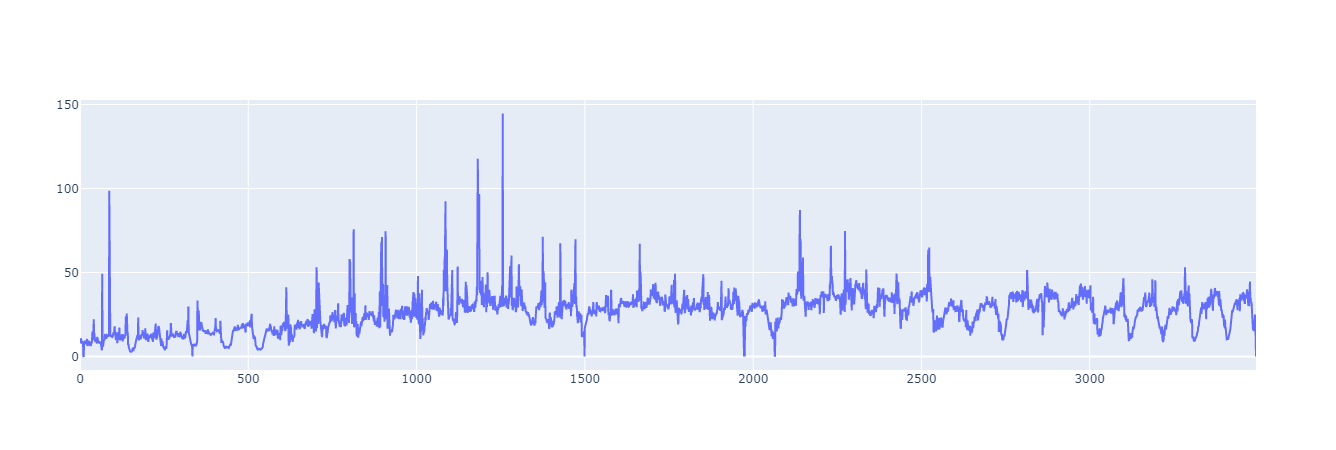

In [19]:
data_34 = data[data["Month"].isin([3, 4])]
go.Figure(data = go.Scatter(y = data_34["chlorophyll"], x = data.index, mode='lines'))

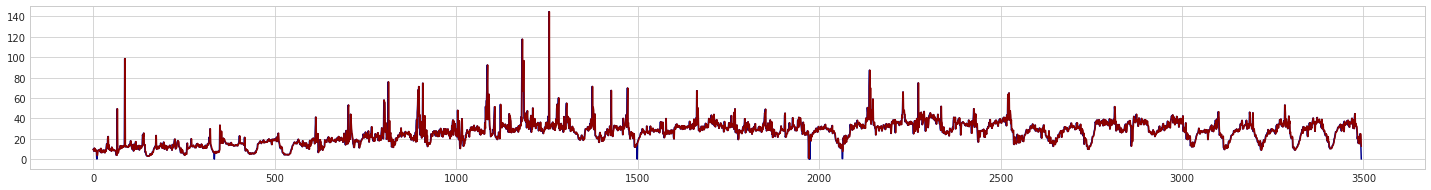

In [20]:
y_ = list(data_34["chlorophyll"])
y__ = [y_[0]]

for i in range(0, len(y_)-1) :

#     if (abs(y_[i] - y_[i-1]) > 50) or (y_[i] < 1) :
    if y_[i] <= 0.5 :
        y_imp = (y_[i-1]+y_[i+1])/2
        y__.append(y_imp) 
    else :
        y__.append(y_[i]) 
        
plt.figure(figsize = (25,3))
plt.plot(data_34["chlorophyll"].reset_index(drop = True), color = "darkblue")
plt.plot(y__, color = "darkred")
plt.ylim(-10, 150);

In [21]:
data_34_ = data_34.copy()
data_34_["chlorophyll"] = y__
# data_34_

In [22]:
# data_3 = data_34_[data_34_["Month"] == 3].reset_index(drop=True)
# data_4 = data_34_[data_34_["Month"] == 4].reset_index(drop=True)
data_3 = data_34[data_34["Month"] == 3].reset_index(drop=True)
data_4 = data_34[data_34["Month"] == 4].reset_index(drop=True)

print(data_3.shape, data_4.shape)

(2969, 569) (526, 569)


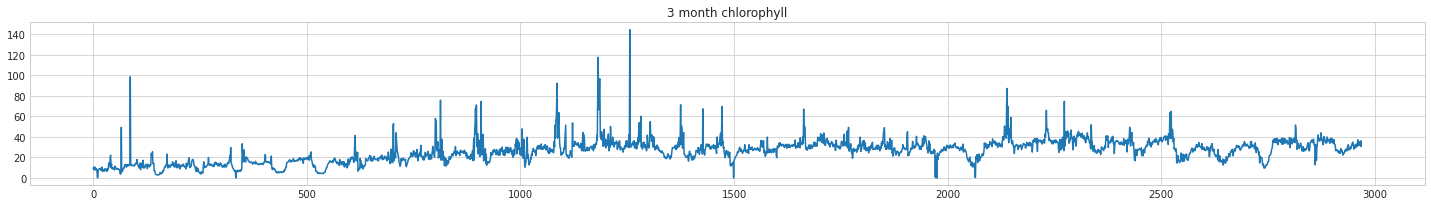

In [23]:
plt.figure(figsize = (25,3))
plt.plot(data_3["chlorophyll"])
plt.title("3 month chlorophyll");

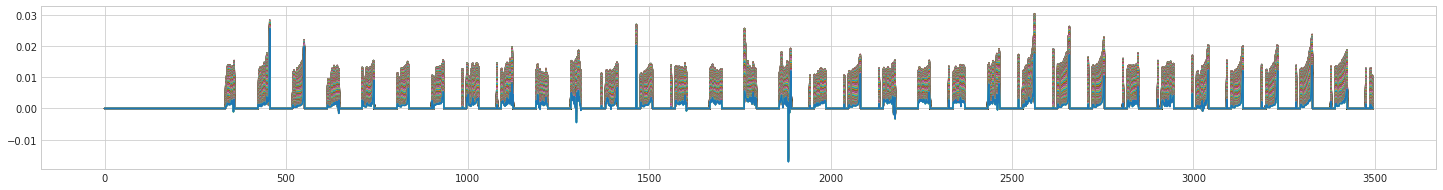

In [37]:
plt.figure(figsize = (25,3))
# aa = data_34_.filter(regex = "reflectance")
plt.plot(aa);

In [35]:
aa.reset_index(drop=True, inplace=True)

In [44]:
c = data_34_["chlorophyll"]*0.001
c.reset_index(drop=True, inplace=True)
aa["c"] = c
aa

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



reflectance.000  reflectance.001  reflectance.002  reflectance.003  \
0            0.000000         0.000000         0.000000         0.000000   
1            0.000000         0.000000         0.000000         0.000000   
2            0.000000         0.000000         0.000000         0.000000   
3            0.000000         0.000000         0.000000         0.000000   
4            0.000000         0.000000         0.000000         0.000000   
...               ...              ...              ...              ...   
3490         0.000000         0.000000         0.000000         0.000000   
3491         0.000000         0.000000         0.000000         0.000000   
3492         0.004619         0.004592         0.004557         0.004516   
3493         0.004180         0.004167         0.004118         0.004074   
3494         0.000000         0.000000         0.000000         0.000000   

      reflectance.004  reflectance.005  reflectance.006  reflectance.007  \
0            0.000000         0.000000         0.000000         0.000000   
1            0.000000         0.000000         0.000000         0.000000   
2            0.000000         0.000000         0.000000         0.000000   
3            0.000000         0.000000         0.000000         0.000000   
4            0.000000         0.000000         0.000000         0.000000   
...               ...              ...              ...              ...   
3490         0.000000         0.000000         0.000000         0.000000   
3491         0.000000         0.000000         0.000000         0.000000   
3492         0.004461         0.004473         0.004443         0.004452   
3493         0.004042         0.004054         0.004031         0.004035   
3494         0.000000         0.000000         0.000000         0.000000   

      reflectance.008  reflectance.009  ...  reflectance.542  reflectance.543  \
0            0.000000         0.000000  ...         0.000000         0.000000   
1            0.000000         0.000000  ...         0.000000         0.000000   
2            0.000000         0.000000  ...         0.000000         0.000000   
3            0.000000         0.000000  ...         0.000000         0.000000   
4            0.000000         0.000000  ...         0.000000         0.000000   
...               ...              ...  ...              ...              ...   
3490         0.000000         0.000000  ...         0.000000         0.000000   
3491         0.000000         0.000000  ...         0.000000         0.000000   
3492         0.004466         0.004475  ...         0.000587         0.000556   
3493         0.004062         0.004057  ...         0.000490         0.000503   
3494         0.000000         0.000000  ...         0.000000         0.000000   

      reflectance.544  reflectance.545  reflectance.546  reflectance.547  \
0            0.000000         0.000000         0.000000         0.000000   
1            0.000000         0.000000         0.000000         0.000000   
2            0.000000         0.000000         0.000000         0.000000   
3            0.000000         0.000000         0.000000         0.000000   
4            0.000000         0.000000         0.000000         0.000000   
...               ...              ...              ...              ...   
3490         0.000000         0.000000         0.000000         0.000000   
3491         0.000000         0.000000         0.000000         0.000000   
3492         0.000539         0.000536         0.000524         0.000499   
3493         0.000453         0.000422         0.000418         0.000397   
3494         0.000000         0.000000         0.000000         0.000000   

      reflectance.548  reflectance.549  reflectance.550        c  
0            0.000000         0.000000         0.000000  0.00955  
1            0.000000         0.000000         0.000000  0.00955  
2            0.000000         0.000000         0.000000  0.00908  
3            0.000000     

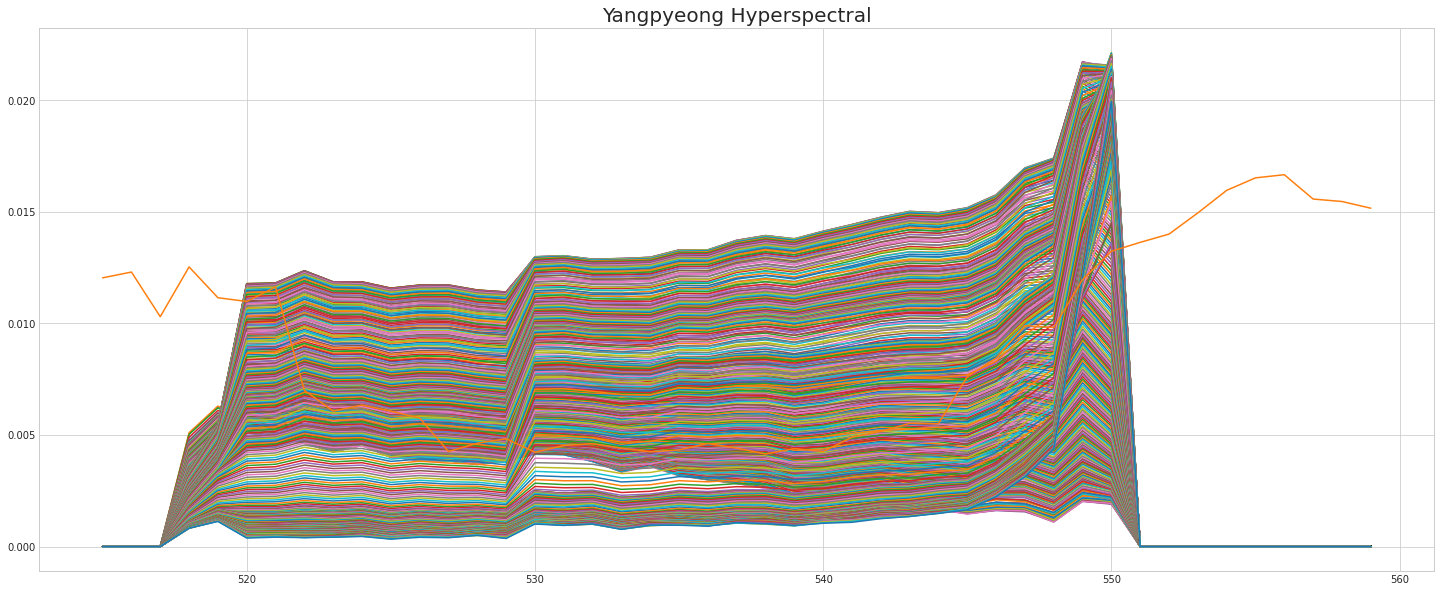

In [49]:
plt.figure(figsize = (25,10))
plt.plot(aa[515:560])
plt.title("Yangpyeong Hyperspectral", fontsize = 20);

In [21]:
parameters = {'max_depth': list(range(1, 21, 5)), 
              'min_samples_leaf': list(range(1, 6, 2)), 
              'min_samples_split':list(range(1, 6, 2)), 
              'n_estimators': list(range(100, 200, 20))}

In [418]:
import warnings
warnings.filterwarnings('ignore')

### 데이터가 쌓일 공간
dataset = data_3.copy()

### 기본 설정
lag_term = 1
Random_state = 717
before_y = "no"
# MODELS = [RandomForestRegressor(random_state = Random_state), ExtraTreesRegressor(random_state = Random_state), AdaBoostRegressor(random_state = Random_state), xgboost.XGBRegressor(random_state = Random_state), 
#           GradientBoostingRegressor(random_state = Random_state), LGBMRegressor(random_state = Random_state), CatBoostRegressor(random_state = Random_state, verbose = 0)]
MODELS = [RandomForestRegressor(random_state = Random_state), xgboost.XGBRegressor(random_state = Random_state), LGBMRegressor(random_state = Random_state)]


### 기본 모델
model = HS_model(data_3, MODEL = GradientBoostingRegressor(random_state = Random_state), lag_term = lag_term)["model"]
print(model)


### 예측 과정
preds = []
for i in tqdm(range(data_4.shape[0])) :
    
    dataset = dataset.append(data_4.iloc[[i]])
    last_data = dataset.iloc[[-1]]
    
    """ 매 0시0분 Model Update """
    if (last_data["Hour"].values == 0) & (last_data["Min"].values == 0) :
        print("\033[31m" +"%d년 %d월 %d일 %d시 %d분 Model Update 수행합니다." % (last_data["Year"], last_data["Month"], last_data["Day"], last_data["Hour"], last_data["Min"]) + "\033[0m")
        
        start_time = time.time()
        
        hs_models, models = [], []
        for j in range(len(MODELS)) :
            hs_model = HS_model(dataset, MODEL = MODELS[j], lag_term = lag_term, before_y = before_y)
            hs_models.append(hs_model)
            models.append(hs_model["model"])

        train_pls = hs_models[0]["train pls"]
        train_std_other = hs_models[0]["train std other"]
        train_std_reflec = hs_models[0]["train std reflec"]
        train_columns = hs_models[0]["train columns"]
        
        end_time = time.time()
        print("%.3f 경과시간" % (np.round(end_time- start_time, 3)))

        
    else :
        pass
    
    """ Prediction """
    pred_X = testlag_(dataset, last_data, lag_term = lag_term, before_y = before_y)
    pred_X = prep_data_with_y(pred_X, train_pls, train_std_other, train_std_reflec)
    pred_X = pred_X[train_columns]
    pred_X_df = pd.concat([pred_X_df, pred_X], axis = 0)    
    
    pred_list = []
    for j in range(len(models)) :
        pred_ = models[j].predict(pred_X)[0]
        pred_list.append(pred_)
        
    pred = np.mean(pred_list)
    
    preds.append(pred)   
    
    if i%50 == 0 :
        print("%d년 %d월 %d일 %d시 %d분 + 15분 후 예측값 : %.4f" % (last_data["Year"], last_data["Month"], last_data["Day"], last_data["Hour"], last_data["Min"], pred))

GradientBoostingRegressor(random_state=717)


  0%|          | 0/526 [00:00<?, ?it/s]

2022년 4월 1일 0시 0분 Model Update 수행합니다.
2.815 경과시간
2022년 4월 1일 0시 0분 + 15분 후 예측값 : 39.2233
2022년 4월 1일 12시 30분 + 15분 후 예측값 : 21.5129
2022년 4월 2일 0시 0분 Model Update 수행합니다.
2.873 경과시간
2022년 4월 2일 1시 0분 + 15분 후 예측값 : 26.1352
2022년 4월 2일 13시 45분 + 15분 후 예측값 : 15.5414
2022년 4월 3일 0시 0분 Model Update 수행합니다.
2.999 경과시간
2022년 4월 3일 2시 15분 + 15분 후 예측값 : 31.7243
2022년 4월 3일 14시 45분 + 15분 후 예측값 : 11.1644
2022년 4월 4일 0시 0분 Model Update 수행합니다.
3.213 경과시간
2022년 4월 4일 3시 30분 + 15분 후 예측값 : 37.7374
2022년 4월 4일 16시 0분 + 15분 후 예측값 : 14.5006
2022년 4월 5일 0시 0분 Model Update 수행합니다.
3.216 경과시간
2022년 4월 5일 4시 30분 + 15분 후 예측값 : 32.4777
2022년 4월 5일 17시 0분 + 15분 후 예측값 : 20.9698
2022년 4월 6일 0시 0분 Model Update 수행합니다.
3.837 경과시간
2022년 4월 6일 5시 30분 + 15분 후 예측값 : 35.4414


R-square(OLS) :  0.827
R-square(sklearn) :  0.826
Correlation :  0.91
MAPE :  261043343.1


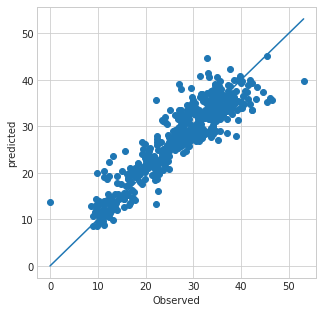

In [454]:
observed = list(data_4.loc[1:, "chlorophyll"].reset_index(drop = True))
preds2 = preds[:-1]

print("R-square(OLS) : ", R2_OLS(observed, preds2))
print("R-square(sklearn) : ", np.round(r2_score(observed, preds2), 3))
print("Correlation : ", np.round(np.corrcoef(observed, preds2)[0,1], 3))
print("MAPE : ", MAPE(observed, preds2))

plt.figure(figsize = (5,5))
plt.scatter(observed, preds2)
plt.xlabel("Observed") ; plt.ylabel("predicted")
plt.plot([0, max(max(observed), max(preds2))], [0, max(max(observed), max(preds2))]);

In [455]:
# display(data_4.head(2))
# display(data_4.tail(2))

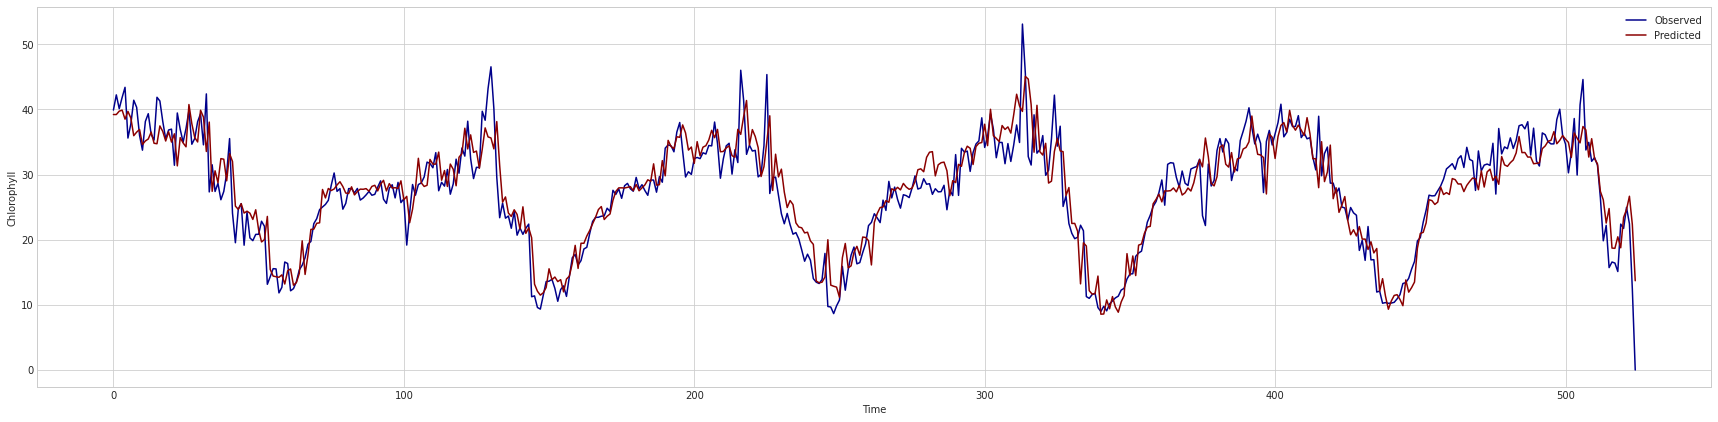

In [456]:
plt.figure(figsize = (30, 7))
plt.plot(observed, color = "darkblue", label = "Observed")
plt.plot(preds2, color = "darkred", label = "Predicted")
plt.xlabel("Time") ; plt.ylabel("Chlorophyll")

plt.legend();

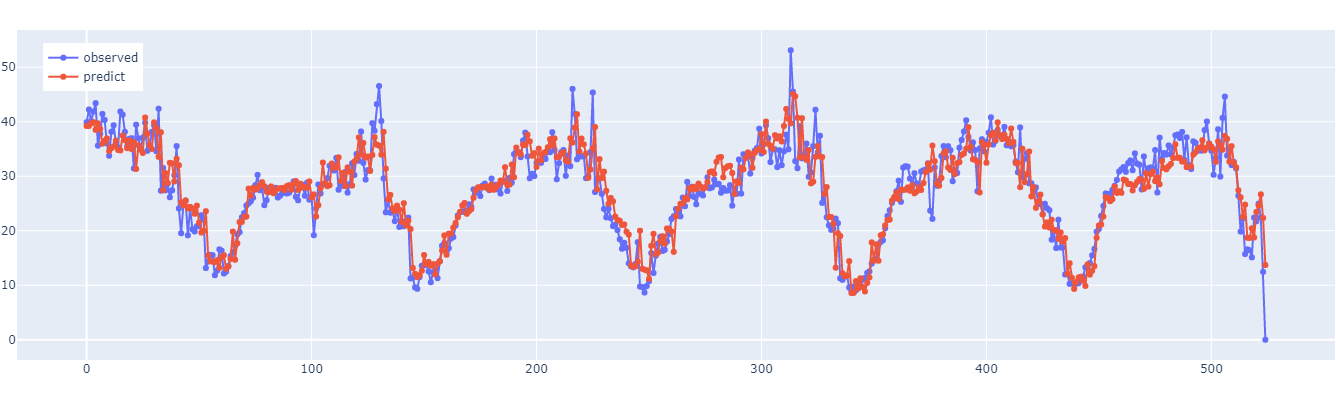

In [521]:
fig = go.Figure()
fig.update_layout(width = 1450, height = 400, margin = dict(l = 1, r = 1, t = 30, b = 40),
                  legend = dict(yanchor='top', y=0.96, xanchor='left', x=0.02))
fig.add_trace(go.Scatter(y = observed, x = list(range(len(observed))), mode = 'lines+markers', name = "observed"))
fig.add_trace(go.Scatter(y = preds2, x = list(range(len(preds2))), mode = 'lines+markers', name = "predict"))
fig.show();